# 2021-2학기 중간과제

# **문제**
tf.keras를 이용해서 CIFAR-10 이미지 분류 문제를 해결하시오.

데이터셋: CIFAR-10
  - http://www.cs.toronto.edu/~kriz/cifar.html
  - https://keras.io/api/datasets/cifar10/  
Reference 코드 활용: 교재, 인터넷 등에서 발견한 코드를 1개 이상 참고하여 이를 수정해서 실험 가능  
  - 원본 소스코드의 출처 명시 필수  
  - 중간고사 범위에서 배운 layer 조합으로 NN을 구성  
  - MLP 기반 (CNN 기반 구조 사용불가)  
  - 제출 형식: 소스코드 및 보고서  
  - 소스코드는 ipynb 형식으로 제출  
  - 보고서는 일반 문서 혹은 ipynb 형식 중 원하는 형태로 제출  
  - 과제 평가 기준
  - 최종 성능: dataset에 정의된 test set에 대한 분류 정확도(accuary) 상대평가  
  - 성실도: 성능 향상을 위해 충분한 비교 실험을 수행했는지 평가  
  - 보고서: 원본 소스에 대한 분석, 실험을 설계한 동기, 실험 결과에 대한 분석 등의 타당성

## **필요한 모듈 임포트**

In [1]:
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

import sklearn
import numpy as np
import os

* keras.backend.clear_session() : Keras에서 생성한 모든 상태를 재설정

## **100개의 뉴런을 가진 은닉층 20개로 심층 신경망 만들기**

In [2]:
keras.backend.clear_session() # 재설정
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))

# He 초기화, ELU 활성화 함수 사용
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 activation="elu",
                                 kernel_initializer="he_normal"))

In [3]:
# 모델에 10개의 뉴런과 소프트맥스 활성화 함수를 사용하는 출력층 추가
model.add(keras.layers.Dense(10, activation="softmax"))

* model.summary() : Sequential Model의 구조를 summery()를 이용하여 확인
    - 레이이어의 구조 또는 총 파라미터의 개수를 확인할 수 있다.

In [4]:
model.summary() # 구조 확인

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 100)               307300    
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 100)               1

In [5]:
# Nadam 옵티마이저 사용
# 학습률 5e-e
optimizer = keras.optimizers.Nadam(learning_rate=5e-5)

- sparse_categorical_crossentropy  
다중 분류 손실 함수
integer type 클래스 -> one-hot encoding하지 않고 정수 형태로 label(y)을 넣어줌  
한 샘플에 여러 클래스가 있거나 label이 soft 확률일 경우 사용

- 정확도(Accuracy)
Accuracy = (TP + TN) / (TP + FP + FN +TN)

In [6]:
# sparse_categorical_crossentropy
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"]) # 옵티마이저 = 나담, 정확도 측정

* CIFAR-10 데이터셋은 10개의 클래스와 32X32 크기의 컬러 이미지 60000개로 구성되어 있다.(훈련 데이터 : 50000, 테스트 데이터 : 10000)  
* 10개의 뉴런과 소프트맥스 활성화 함수를 출력층으로 사용

In [7]:
# CIFAR-10 데이터 로드
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()
# 원본 훈련 세트에서 처음 5000개를 검증 세트로 사용
X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

170508288/170498071 [==============================] - 2s 0us/step


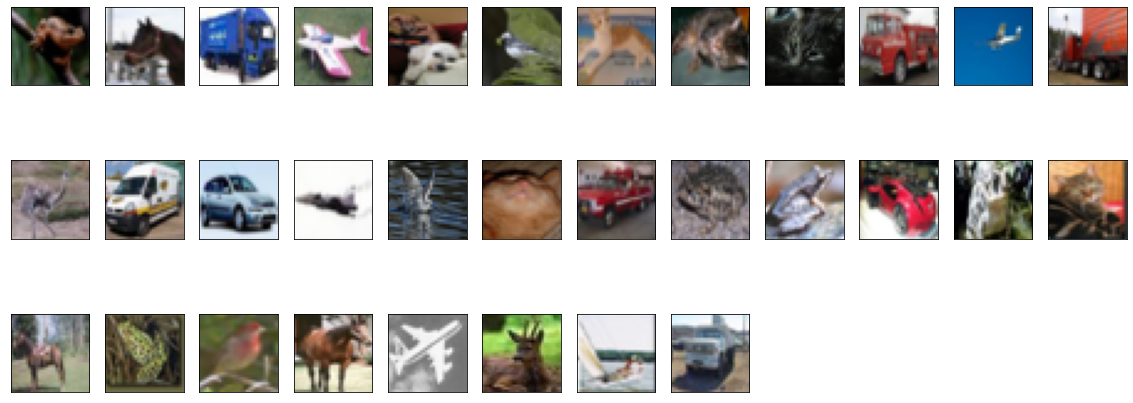

In [8]:
# 데이터 시각화
import matplotlib.pyplot as plt
figure = plt.figure(figsize=[20, 8])
# 학습시킬 이미지 subset을 5개 시각화하여 확인
for i in range(32) :
  ax = figure.add_subplot(3, 12, i+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(X_train[i]))

In [9]:
# 콜백을 만들고 모델 훈련
# 조기 종료 사용
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)
run_index = 1 # 모델을 훈련할 때마다 증가시킴
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [10]:
# 모델 학습
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 25s 15ms/step - loss: 3.9882 - accuracy: 0.1750 - val_loss: 2.1041 - val_accuracy: 0.2368
Epoch 2/100
1407/1407 [==============================] - 20s 14ms/step - loss: 2.0415 - accuracy: 0.2551 - val_loss: 2.1067 - val_accuracy: 0.2406
Epoch 3/100
1407/1407 [==============================] - 20s 14ms/step - loss: 1.9307 - accuracy: 0.2952 - val_loss: 1.9628 - val_accuracy: 0.2804
Epoch 4/100
1407/1407 [==============================] - 20s 14ms/step - loss: 1.8526 - accuracy: 0.3225 - val_loss: 1.8137 - val_accuracy: 0.3412
Epoch 5/100
1407/1407 [==============================] - 20s 14ms/step - loss: 1.7864 - accuracy: 0.3496 - val_loss: 1.8074 - val_accuracy: 0.3374
Epoch 6/100
1407/1407 [==============================] - 20s 14ms/step - loss: 1.7375 - accuracy: 0.3695 - val_loss: 1.7179 - val_accuracy: 0.3798
Epoch 7/100
1407/1407 [==============================] - 20s 14ms/step - loss: 1.6983 - accuracy: 0.3864 - val_loss: 1

In [11]:
# 모델 평가
model = keras.models.load_model("my_cifar10_model.h5")
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 1s 3ms/step - loss: 1.5154 - accuracy: 0.4812


[1.515366554260254, 0.4812000095844269]

약 48.1%의 정확도를 얻음

## **배치정규화로 모델 정의**

In [12]:
# 배치 정규화 추가
# 출력층을 제외하고 모든 Dense 층 다음에 BN층을 추가(처음 은닉층 전에도 추가)
# 학습률은 5e-4로 바꿈

keras.backend.clear_session() # 재설정
tf.random.set_seed(42)
np.random.seed(42)

# 모델 정의 및 추가
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.summary() # 구조 확인

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 batch_normalization (BatchN  (None, 3072)             12288     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 100)               307300    
                                                                 
 batch_normalization_1 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               1

In [13]:
# Nadam 옵티마이저 사용
optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

# 콜백함수
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_bn_model.h5", save_best_only=True)
run_index = 1 # 모델을 훈련할 때마다 증가시킴
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_bn_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

# 모델 학습
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

# 모델 평가
model = keras.models.load_model("my_cifar10_bn_model.h5")
model.evaluate(X_valid, y_valid)

Epoch 1/100
1407/1407 [==============================] - 41s 22ms/step - loss: 1.8462 - accuracy: 0.3394 - val_loss: 1.6817 - val_accuracy: 0.4050
Epoch 2/100
1407/1407 [==============================] - 30s 21ms/step - loss: 1.6724 - accuracy: 0.4062 - val_loss: 1.6114 - val_accuracy: 0.4206
Epoch 3/100
1407/1407 [==============================] - 30s 21ms/step - loss: 1.5975 - accuracy: 0.4324 - val_loss: 1.5443 - val_accuracy: 0.4548
Epoch 4/100
1407/1407 [==============================] - 30s 21ms/step - loss: 1.5475 - accuracy: 0.4485 - val_loss: 1.5008 - val_accuracy: 0.4596
Epoch 5/100
1407/1407 [==============================] - 30s 21ms/step - loss: 1.5069 - accuracy: 0.4644 - val_loss: 1.4573 - val_accuracy: 0.4838
Epoch 6/100
1407/1407 [==============================] - 30s 21ms/step - loss: 1.4688 - accuracy: 0.4789 - val_loss: 1.4245 - val_accuracy: 0.4936
Epoch 7/100
1407/1407 [==============================] - 30s 21ms/step - loss: 1.4379 - accuracy: 0.4880 - val_loss: 1

[1.3280383348464966, 0.5424000024795532]

약 54.2%의 정확도를 얻음  
이전 모델보다 더 좋은 성능을 보임

## **SELU 활성화 함수 사용해서 모델 정의**

In [14]:
keras.backend.clear_session() # 재설정
tf.random.set_seed(42)
np.random.seed(42)

# 모델 정의
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))

# 네트워크가 자기 정규화를 해야 하기 때문에
# 르쿤 정규분포 초기화
# SELU 활성화 함수 사용 
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.summary() # 구조 확인

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 100)               307300    
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 100)               1

In [15]:
optimizer = keras.optimizers.Nadam(learning_rate=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

# 콜백 함수
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_selu_model.h5", save_best_only=True)
run_index = 1 # 모델을 훈련할 때마다 증가시킴
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_selu_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

# 데이터 정규화
X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

# 모델 학습
model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 25s 15ms/step - loss: 1.9176 - accuracy: 0.3125 - val_loss: 1.8557 - val_accuracy: 0.3402
Epoch 2/100
1407/1407 [==============================] - 20s 14ms/step - loss: 1.7046 - accuracy: 0.3943 - val_loss: 1.7404 - val_accuracy: 0.3784
Epoch 3/100
1407/1407 [==============================] - 20s 14ms/step - loss: 1.6085 - accuracy: 0.4348 - val_loss: 1.7106 - val_accuracy: 0.3906
Epoch 4/100
1407/1407 [==============================] - 20s 14ms/step - loss: 1.5486 - accuracy: 0.4558 - val_loss: 1.6228 - val_accuracy: 0.4376
Epoch 5/100
1407/1407 [==============================] - 20s 15ms/step - loss: 1.4902 - accuracy: 0.4764 - val_loss: 1.6360 - val_accuracy: 0.4288
Epoch 6/100
1407/1407 [==============================] - 20s 14ms/step - loss: 1.4453 - accuracy: 0.4922 - val_loss: 1.5338 - val_accuracy: 0.4578
Epoch 7/100
1407/1407 [==============================] - 19s 14ms/step - loss: 1.4072 - accuracy: 0.5069 - val_loss: 1

[1.4628735780715942, 0.49779999256134033]

In [16]:
model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)

157/157 [==============================] - 1s 4ms/step - loss: 1.4629 - accuracy: 0.4978


[1.4628735780715942, 0.49779999256134033]

약 49.8%의 정확도 얻음  
배치 정규화를 사용한 모델만큼 성능이 좋지 않지만 빠르게 수렴했다.

## **알파 드롭아웃으로 모델 규제**

In [17]:
keras.backend.clear_session() # 재설정
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_alpha_dropout_model.h5", save_best_only=True)
run_index = 1 # 모델을 훈련할 때마다 증가시킴
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_alpha_dropout_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_alpha_dropout_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 26s 16ms/step - loss: 1.9022 - accuracy: 0.3237 - val_loss: 1.7034 - val_accuracy: 0.3894
Epoch 2/100
1407/1407 [==============================] - 22s 16ms/step - loss: 1.6717 - accuracy: 0.4070 - val_loss: 1.7202 - val_accuracy: 0.4034
Epoch 3/100
1407/1407 [==============================] - 22s 16ms/step - loss: 1.5773 - accuracy: 0.4488 - val_loss: 1.6244 - val_accuracy: 0.4290
Epoch 4/100
1407/1407 [==============================] - 22s 16ms/step - loss: 1.5122 - accuracy: 0.4718 - val_loss: 1.5603 - val_accuracy: 0.4674
Epoch 5/100
1407/1407 [==============================] - 22s 16ms/step - loss: 1.4565 - accuracy: 0.4900 - val_loss: 1.6625 - val_accuracy: 0.4594
Epoch 6/100
1407/1407 [==============================] - 22s 16ms/step - loss: 1.4054 - accuracy: 0.5113 - val_loss: 1.5159 - val_accuracy: 0.4774
Epoch 7/100
1407/1407 [==============================] - 22s 16ms/step - loss: 1.3612 - accuracy: 0.5250 - val_loss: 1

[1.4959454536437988, 0.483599990606308]

In [18]:
# AlphaDropout 클래스를 상속하여 MCAlpha Dropout 클래스 정의
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [19]:
# AlphaDropout 층 대신 MCAlphaDropout 드롭아웃 층을 사용
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [20]:
# 모델을 여러번 실행
# 평균한 예측 클래스 확률을 반환
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

# 함수 mc_dropout_predict_probas의 평균 확률을 사용해 각 샘플의 클래스를 예측
def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

In [21]:
keras.backend.clear_session() # 재설정
tf.random.set_seed(42)
np.random.seed(42)

# 검증 세트의 모든 샘플에 대해 예측을 만들고
y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)

# 정확도 계산
accuracy = np.mean(y_pred == y_valid[:, 0])
accuracy

0.4836

약 48%의 정확도 얻음  
이전 배치정규화 모델보다 성능이 높지 않다.

## **1사이클 스케줄링으로 모델 정의**

In [22]:
keras.backend.clear_session() # 재설정
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [23]:
import math
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [24]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

In [25]:
# 학습률에 대한 학습 곡선 함수 정의
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

352/352 [==============================] - 7s 18ms/step - loss: nan - accuracy: 0.1379


(9.999999747378752e-06,
 9.615227699279785,
 2.6123199462890625,
 4.002794538225447)

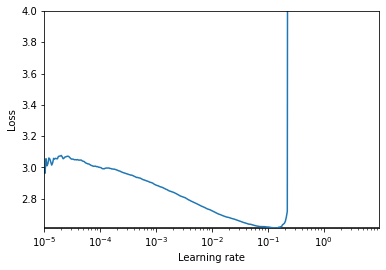

In [26]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [27]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))

# 르쿤 정규화, SELU 활성화 함수 사용
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

# 모델 추가
model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax")) # 출력층

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [28]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [29]:
n_epochs = 15
onecycle = OneCycleScheduler(len(X_train_scaled) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/15
352/352 [==============================] - 8s 19ms/step - loss: 2.0532 - accuracy: 0.2864 - val_loss: 1.7470 - val_accuracy: 0.3846
Epoch 2/15
352/352 [==============================] - 6s 18ms/step - loss: 1.7630 - accuracy: 0.3765 - val_loss: 1.6308 - val_accuracy: 0.4276
Epoch 3/15
352/352 [==============================] - 6s 18ms/step - loss: 1.6147 - accuracy: 0.4256 - val_loss: 1.6498 - val_accuracy: 0.4268
Epoch 4/15
352/352 [==============================] - 6s 18ms/step - loss: 1.5412 - accuracy: 0.4525 - val_loss: 1.6208 - val_accuracy: 0.4324
Epoch 5/15
352/352 [==============================] - 6s 18ms/step - loss: 1.4883 - accuracy: 0.4734 - val_loss: 1.6611 - val_accuracy: 0.4428
Epoch 6/15
352/352 [==============================] - 6s 18ms/step - loss: 1.4454 - accuracy: 0.4866 - val_loss: 1.5653 - val_accuracy: 0.4586
Epoch 7/15
352/352 [==============================] - 6s 18ms/step - loss: 1.4107 - accuracy: 0.4988 - val_loss: 1.5673 - val_accuracy: 0.4630

약 53.7% 정확도를 얻음  
1사이클 방식은 이전 모델들보다 빠르게 훈련했고 그만큼 모델 성능도 올라갔다.  
배치 정규화 모델보다 조금 정확도는 낮지만 훈련속도는 더 빠르다.

# **참고 코드 출처**
* https://github.com/rickiepark/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb